In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.utils import shuffle

## Data Input and Suffle Data
- Read data from kaggle notebook input folder
- Observe the label value counts distribution

In [2]:
df = pd.read_json("../input/recipe/train.json")
df = shuffle(df, random_state =52)
df.set_index('id', inplace = True)

df_sub = pd.read_json("../input/recipe/test.json")

print(df["cuisine"].value_counts())
print(df.shape, df_sub.shape)

italian         5935
mexican         4788
southern_us     3207
indian          2283
french          1997
chinese         1986
cajun_creole    1156
thai            1120
japanese        1080
greek            876
spanish          729
vietnamese       626
moroccan         620
korean           611
british          594
filipino         579
irish            497
jamaican         396
russian          363
brazilian        331
Name: cuisine, dtype: int64
(29774, 2) (10000, 2)


## Data Preprocessing
1. Create a simple funtion: simplified_ingre to reduce each ingredients to only two last words, in order to eliminate the additional adj. in front of some ingredients.
2. For each data(row) combine every one of its ingredients to a single string, so that TfidfVectorizer can correctly do the trick to exract features.

In [3]:
def simplified_ingre(ingre):
    simp_ingre = []
    for i in ingre:
        ii = i.split(' ')
        if len(ii) >= 2:
            simp_ingre.append(ii[len(ii) - 2] + ' ' + ii[len(ii) - 1])
        else:
            simp_ingre.append(ii[0])
    return simp_ingre
    
df['ingredients'] = df['ingredients'].apply(simplified_ingre)
df_sub['ingredients'] = df_sub['ingredients'].apply(simplified_ingre)

In [4]:
df['recipe'] = df['ingredients'].str.join(' ')
df_sub['recipe'] = df_sub['ingredients'].str.join(' ')

In [5]:
print(df.columns, df.shape)

Index(['cuisine', 'ingredients', 'recipe'], dtype='object') (29774, 3)


In [6]:
X = df['recipe']
X_sub = df_sub['recipe']
y = df['cuisine']

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.30, random_state = 0)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(binary=True)  
X_train = vectorizer.fit_transform(X_train).todense()
X_vali = vectorizer.transform(X_vali).todense()
X_sub = vectorizer.transform(X_sub).todense()

## Model Construction
- Different kernel, such as poly, rbf both took lots of time to train, so in the end I choose LinearSVC, a similar model of SVC with linear kernel, but better at handling large amount of data, besides, it also performs better than other kernels.  

In [9]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC()

In [10]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes )
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Results

              precision    recall  f1-score   support

   brazilian       0.68      0.47      0.55       115
     british       0.57      0.48      0.52       170
cajun_creole       0.72      0.70      0.71       320
     chinese       0.77      0.86      0.81       574
    filipino       0.66      0.54      0.59       177
      french       0.59      0.64      0.61       572
       greek       0.72      0.69      0.71       251
      indian       0.83      0.88      0.86       684
       irish       0.65      0.38      0.48       159
     italian       0.82      0.89      0.85      1853
    jamaican       0.80      0.72      0.76       112
    japanese       0.82      0.70      0.75       334
      korean       0.80      0.76      0.78       177
     mexican       0.89      0.93      0.91      1397
    moroccan       0.80      0.74      0.77       200
     russian       0.58      0.45      0.51       116
 southern_us       0.73      0.77      0.75       962
     spanish       0.67    

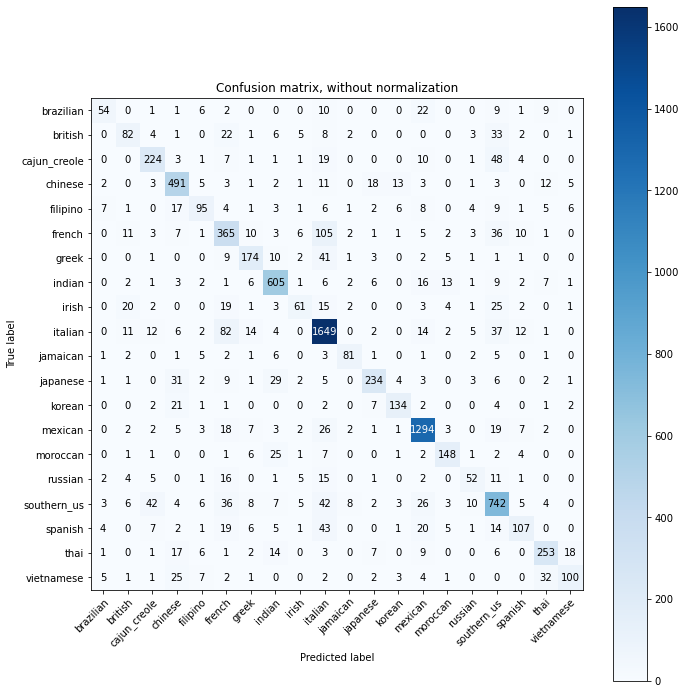

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

y_true, y_pred = y_vali, svc.predict(X_vali)
print(classification_report(y_true, y_pred))
plot_confusion_matrix(y_true, y_pred, classes=np.sort(y_train.unique()), cmap=plt.cm.Blues)
plt.show()

## Comparison & Conclusion 
- please refer to ANN.html, thanks